## Задание
Используя данные из обучающего датасета train.csv, построить модель для предсказания цен на недвижимость (квартиры).

С помощью полученной модели, предсказать цены для квартир из тестового датасета test.csv.

Целевая переменная: Price

Метрика качества: R2 - коэффициент детерминации (sklearn.metrics.r2_score)

## Требования к решению
Необходимо получить R2 > 0.6 на Private Leaderboard.

Укажите свой ник на kaggle
Примечание: Все файлы csv должны содержать названия полей (header - то есть "шапку"), разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.

In [1]:
# 1. Основные библиотеки
import pandas as pd
import numpy as np
import random
import pickle 

import matplotlib
import matplotlib.image as img
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
from datetime import datetime
# 2. Разделение датасета
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
# 3. Метрики качества
from sklearn.metrics import mean_squared_error as mse, r2_score as r2
# 4. Модели
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
matplotlib.rcParams.update({'font.size': 14})  # размер шрифта на графиках

## Пути к директориям и файлам

In [4]:
import os
notebook_path = os.path.abspath("C:/Users/Sidwrite/Desktop/Проект/дз.ipynb")
TRAIN_DATASET_PATH = os.path.join(os.path.dirname(notebook_path), "C:/Users/Sidwrite/Desktop/Проект/train.csv")
TEST_DATASET_PATH = os.path.join(os.path.dirname(notebook_path), "C:/Users/Sidwrite/Desktop/Проект/test.csv")
TEST_DATASET_EXT_PATH = "C:/Users/Sidwrite/Desktop/Проект/ShishkovaME_predictions.csv"
REPORTS_FILE_PATH = "C:/Users/Sidwrite/Desktop/Проект/"
SCALER_FILE_PATH =  "C:/Users/Sidwrite/Desktop/Проект/scaler.pkl"
MODEL_FILE_PATH =  "C:/Users/Sidwrite/Desktop/Проект/model.pkl"


# Шаг 1. Загрузка данных

In [5]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
#                 if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
#                     df[col] = df[col].astype(np.float16)
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

### Описание датасета

**Описание датасета**
* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** -жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [6]:
df = pd.read_csv(TRAIN_DATASET_PATH)
df.head()

Id  DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
0  11809          27    3.0  115.027311         NaN           10.0      4   
1   3013          22    1.0   39.832524   23.169223            8.0      7   
2   8215           1    3.0   78.342215   47.671972           10.0      2   
3   2352           1    1.0   40.409907         NaN            1.0     10   
4  13866          94    2.0   64.285067   38.562517            9.0     16   

   HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  Social_2  \
0        10.0       2014   0.075424         B         B        11      3097   
1         8.0       1966   0.118537         B         B        30      6207   
2        17.0       1988   0.025609         B         B        33      5261   
3        22.0       1977   0.007122         B         B         1       264   
4        16.0       1972   0.282798         B         B        33      8667   

   Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2          Price  
0         0           NaN            0        0       B  305018.871089  
1         1        1183.0            1        0       B  177734.553407  
2         0         240.0            3        1       B  282078.720850  
3         0           NaN            0        1       B  168106.007630  
4         2           NaN            0        6       B  343995.102962

In [7]:
df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [8]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.tail()

Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
4995  10379          29    2.0  43.177521   30.339945            5.0      6   
4996  16138          38    3.0  93.698122   94.521465           10.0     21   
4997   3912         101    1.0  33.656723   19.003259            5.0      2   
4998   5722          10    1.0  38.635155   20.976257            9.0      8   
4999  11004          21    2.0  67.122742   33.944344           13.0      9   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
4995         5.0       1962   0.069660         B         B        31   
4996        27.0       2018   0.060753         B         B        15   
4997         5.0       1966   0.038693         B         B        28   
4998        14.0       1970   0.089040         B         B        33   
4999        17.0       2009   0.194489         B         B        47   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  
4995      6119         4           NaN            1        2       B  
4996      2787         2         520.0            0        7       B  
4997      6533         1        1015.0            2        5       B  
4998      7976         5           NaN            0       11       B  
4999      8004         3         125.0            3        5       B

In [9]:
print('Строк в трейне:', df.shape[0])
print('Строк в тесте', test_df.shape[0])

Строк в трейне: 10000
Строк в тесте 5000


### 2. Приведение типов данных

In [10]:
df['Id'] = df['Id'].astype(str)
df['DistrictId'] = df['DistrictId'].astype(str)

## EDA

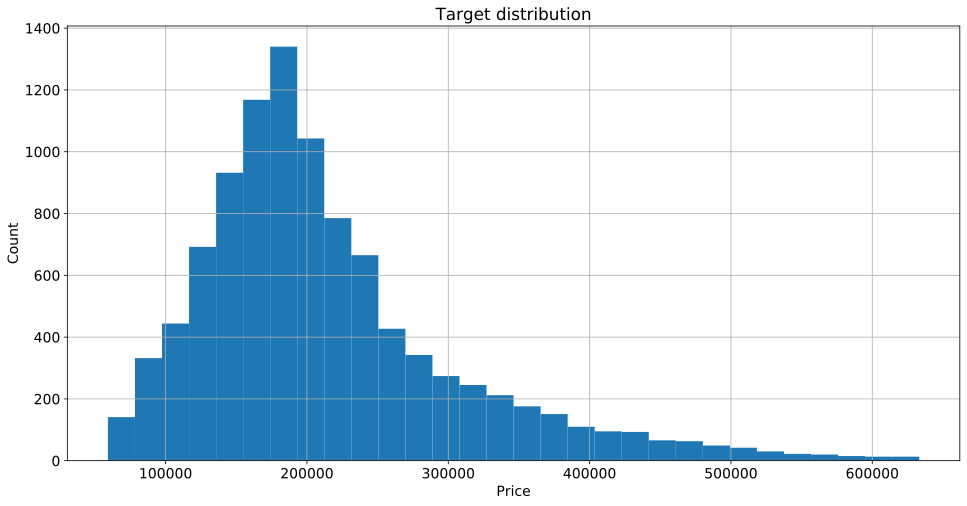

In [11]:
plt.figure(figsize = (16, 8))

df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

Количественные переменные

In [12]:
df.describe()

Rooms        Square   LifeSquare  KitchenSquare         Floor  \
count  10000.000000  10000.000000  7887.000000   10000.000000  10000.000000   
mean       1.890500     56.315775    37.199645       6.273300      8.526700   
std        0.839512     21.058732    86.241209      28.560917      5.241148   
min        0.000000      1.136859     0.370619       0.000000      1.000000   
25%        1.000000     41.774881    22.769832       1.000000      4.000000   
50%        2.000000     52.513310    32.781260       6.000000      7.000000   
75%        2.000000     65.900625    45.128803       9.000000     12.000000   
max       19.000000    641.065193  7480.592129    2014.000000     42.000000   

         HouseFloor     HouseYear     Ecology_1      Social_1      Social_2  \
count  10000.000000  1.000000e+04  10000.000000  10000.000000  10000.000000   
mean      12.609400  3.990166e+03      0.118858     24.687000   5352.157400   
std        6.775974  2.005003e+05      0.119025     17.532614   4006.799803   
min        0.000000  1.910000e+03      0.000000      0.000000    168.000000   
25%        9.000000  1.974000e+03      0.017647      6.000000   1564.000000   
50%       13.000000  1.977000e+03      0.075424     25.000000   5285.000000   
75%       17.000000  2.001000e+03      0.195781     36.000000   7227.000000   
max      117.000000  2.005201e+07      0.521867     74.000000  19083.000000   

           Social_3  Healthcare_1   Helthcare_2       Shops_1          Price  
count  10000.000000   5202.000000  10000.000000  10000.000000   10000.000000  
mean       8.039200   1142.904460      1.319500      4.231300  214138.857399  
std       23.831875   1021.517264      1.493601      4.806341   92872.293865  
min        0.000000      0.000000      0.000000      0.000000   59174.778028  
25%        0.000000    350.000000      0.000000      1.000000  153872.633942  
50%        2.000000    900.000000      1.000000      3.000000  192269.644879  
75%        5.000000   1548.000000      2.000000      6.000000  249135.462171  
max      141.000000   4849.000000      6.000000     23.000000  633233.466570

In [13]:
# Функция для отображения scatter-графика по двум признакам.
def draw_scatter(column_x, column_y, df):
    plt.scatter(df[column_x], df[column_y])
    plt.xlabel(column_x)
    plt.ylabel(column_y)
    plt.show()

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  object 
 1   DistrictId     10000 non-null  object 
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [15]:
df.select_dtypes(include='object').columns.tolist()

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [16]:
df['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
207      1
174      1
196      1
205      1
209      1
Name: DistrictId, Length: 205, dtype: int64

## Обработка пропусков

In [17]:
df.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

## Healthcare_1

In [18]:
#Признак Healthcare_1 содержит очень много пропущенных значений. Не будем учитывать этот признак.
df.drop(['Healthcare_1'], axis=1, inplace=True)

In [19]:
#Найдём долю жилой площади от общей по средним значениям в выборке и заполним пропущенные значения в столбце LifeSquare.
square_mean_values = df[['Square', 'LifeSquare']].dropna().mean()
square_coeff = square_mean_values[1] / square_mean_values[0]
square_coeff

0.673488604742028

In [20]:
df.loc[df['LifeSquare'].isnull(), 'LifeSquare'] = df['Square'] * square_coeff

In [21]:
df.isna().sum()

Id               0
DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Helthcare_2      0
Shops_1          0
Shops_2          0
Price            0
dtype: int64

## Обработка выбросов

In [22]:
df.describe()

Rooms        Square    LifeSquare  KitchenSquare         Floor  \
count  10000.000000  10000.000000  10000.000000   10000.000000  10000.000000   
mean       1.890500     56.315775     37.928033       6.273300      8.526700   
std        0.839512     21.058732     76.927395      28.560917      5.241148   
min        0.000000      1.136859      0.370619       0.000000      1.000000   
25%        1.000000     41.774881     24.836514       1.000000      4.000000   
50%        2.000000     52.513310     33.626900       6.000000      7.000000   
75%        2.000000     65.900625     45.345463       9.000000     12.000000   
max       19.000000    641.065193   7480.592129    2014.000000     42.000000   

         HouseFloor     HouseYear     Ecology_1      Social_1      Social_2  \
count  10000.000000  1.000000e+04  10000.000000  10000.000000  10000.000000   
mean      12.609400  3.990166e+03      0.118858     24.687000   5352.157400   
std        6.775974  2.005003e+05      0.119025     17.532614   4006.799803   
min        0.000000  1.910000e+03      0.000000      0.000000    168.000000   
25%        9.000000  1.974000e+03      0.017647      6.000000   1564.000000   
50%       13.000000  1.977000e+03      0.075424     25.000000   5285.000000   
75%       17.000000  2.001000e+03      0.195781     36.000000   7227.000000   
max      117.000000  2.005201e+07      0.521867     74.000000  19083.000000   

           Social_3   Helthcare_2       Shops_1          Price  
count  10000.000000  10000.000000  10000.000000   10000.000000  
mean       8.039200      1.319500      4.231300  214138.857399  
std       23.831875      1.493601      4.806341   92872.293865  
min        0.000000      0.000000      0.000000   59174.778028  
25%        0.000000      0.000000      1.000000  153872.633942  
50%        2.000000      1.000000      3.000000  192269.644879  
75%        5.000000      2.000000      6.000000  249135.462171  
max      141.000000      6.000000     23.000000  633233.466570

### LifeSquare. Square

In [23]:
df['LifeSquare'].describe() #видно, что максимальное значение равно 7480,
#в то время как 75% квантиль равен только 45. Значение 7480 – выброс.

count    10000.000000
mean        37.928033
std         76.927395
min          0.370619
25%         24.836514
50%         33.626900
75%         45.345463
max       7480.592129
Name: LifeSquare, dtype: float64

In [24]:
df['Square'].describe()

count    10000.000000
mean        56.315775
std         21.058732
min          1.136859
25%         41.774881
50%         52.513310
75%         65.900625
max        641.065193
Name: Square, dtype: float64

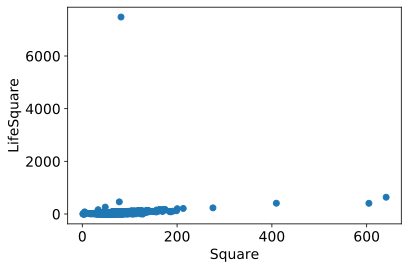

In [25]:
draw_scatter('Square', 'LifeSquare', df)

In [26]:
#мы удалим «лишние» значения, руководствуясь определением экстремальных аномалий:
# Вычислить первый и третий квартиль
first_quartile = df['LifeSquare'].describe()['25%']
third_quartile = df['LifeSquare'].describe()['75%']

# Межквартильный размах
iqr = third_quartile - first_quartile

# Удалить выбросы
df = df[(df['LifeSquare'] > (first_quartile - 1.5 * iqr)) &
            (df['LifeSquare'] < (third_quartile + 1.5 * iqr))]

In [27]:
# Вычислить первый и третий квартиль
first_quartile = df['Square'].describe()['25%']
third_quartile = df['Square'].describe()['75%']

# Межквартильный размах
iqr = third_quartile - first_quartile

# Удалить выбросы
df = df[(df['Square'] > (first_quartile - 1.5 * iqr)) &
            (df['Square'] < (third_quartile + 1.5 * iqr))]

### Rooms

In [28]:
# Заменим количество комнат =0 на 1, при количестве больше 6 медианой.
df.loc[df['Rooms'] == 0, 'Rooms'] = 1
df.loc[df['Rooms'] >= 6, 'Rooms'] = df['Rooms'].median()

In [29]:
df['Rooms'].value_counts()

2.0    3833
1.0    3672
3.0    1938
4.0      78
5.0       5
Name: Rooms, dtype: int64

### KitchenSquare

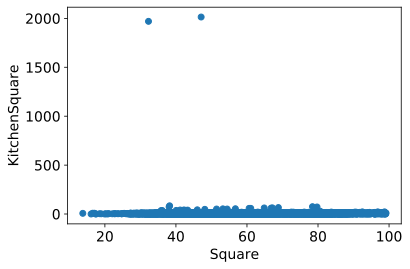

In [30]:
draw_scatter('Square', 'KitchenSquare', df)

In [31]:
# Найдём долю площади кухни от общей по средним значениям в выборке и заполним пропущенные значения в столбце KitchenSquare.
#мы удалим «лишние» значения, руководствуясь определением экстремальных аномалий:
# Вычислить первый и третий квартиль
first_quartile = df['KitchenSquare'].describe()['25%']
third_quartile = df['KitchenSquare'].describe()['75%']

# Межквартильный размах
iqr = third_quartile - first_quartile

# Удалить выбросы
df = df[(df['KitchenSquare'] > (first_quartile - 1.5 * iqr)) &
            (df['KitchenSquare'] < (third_quartile + 1.5 * iqr))]

In [32]:
KitchenSquare_mean_values = df[['Square', 'KitchenSquare']].dropna().mean()
KitchenSquare_coeff = KitchenSquare_mean_values[1] / KitchenSquare_mean_values[0]
KitchenSquare_coeff

0.1055078255635599

In [33]:
#Найдем нулевые значения в KitchenSquare и заменим на средние значения в выборке
df.loc[df['KitchenSquare'] == 0, 'KitchenSquare'] = df['Square'] * KitchenSquare_coeff

In [34]:
#Заменим значение меньше 3 на 3
df.loc[df['KitchenSquare'] < 3, 'KitchenSquare'] = 3

In [35]:
df['KitchenSquare'].value_counts()

3.000000     2292
8.000000     1301
5.000000     1167
6.000000     1035
10.000000    1007
             ... 
7.063740        1
6.685797        1
7.086778        1
4.516280        1
5.534686        1
Name: KitchenSquare, Length: 644, dtype: int64

### Floor. HouseFloor

In [36]:
#Заменим значения равные 0 на медиану
df.loc[df['Floor'] == 0, 'Floor'] = df['Floor'].median()

In [37]:
df.loc[df['HouseFloor'] == 0, 'HouseFloor'] = df['HouseFloor'].median()

### HouseYear

In [38]:
# Заменим значения больше 2020 года на значение равное 2020
df.loc[df['HouseYear'] > 2020, 'HouseYear'] = 2020

 ## Построение новых признаков

In [39]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians=None
        self.first_quartile_LifeSquare=None
        self.third_quartile_LifeSquare=None
        self.first_quartile_KitchenSquare=None
        self.third_quartile_KitchenSquare=None
        self.first_quartile_Square=None
        self.third_quartile_Square=None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        self.first_quartile_LifeSquare = X['LifeSquare'].describe()['25%']
        self.third_quartile_LifeSquare = X['LifeSquare'].describe()['75%']
        self.first_quartile_KitchenSquare = X['KitchenSquare'].describe()['25%']
        self.third_quartile_KitchenSquare = X['KitchenSquare'].describe()['75%'] 
        self.first_quartile_Square = X['Square'].describe()['25%']
        self.third_quartile_Square = X['Square'].describe()['75%']
    
    def transform(self, X):
        """Трансформация данных"""

        # Rooms
              
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']
        
        
        
        KitchenSquare_mean_values = X[['Square', 'KitchenSquare']].dropna().mean()
        KitchenSquare_coeff = KitchenSquare_mean_values[1] / KitchenSquare_mean_values[0]
        X.loc[X['KitchenSquare'] == 0, 'KitchenSquare'] = X['Square'] * KitchenSquare_coeff
        
                         
        # HouseFloor, Floor
                
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        X.loc[X['Floor'] == 0, 'Floor'] = self.medians['Floor']
     
        # HouseYear
        current_year = datetime.now().year
                    
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
            
         
                    
        
        X.fillna(self.medians, inplace=True)
        
        return X

In [40]:
#преобразования каитегориальных переменных в булевые, если они принимают только два значения.
binary_to_numbers = {'A': 0, 'B': 1}

df['Ecology_2'] = df['Ecology_2'].replace(binary_to_numbers)
df['Ecology_3'] = df['Ecology_3'].replace(binary_to_numbers)
df['Shops_2'] = df['Shops_2'].replace(binary_to_numbers)

In [41]:
district_size = df['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head()

DistrictId  DistrictSize
0         27           784
1          1           617
2         23           529
3          6           494
4          9           283

In [42]:
df = df.merge(district_size, on='DistrictId', how='left')
df.head()

Id DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
0   3013         22    1.0  39.832524   23.169223            8.0    7.0   
1   8215          1    3.0  78.342215   47.671972           10.0    2.0   
2   2352          1    1.0  40.409907   27.215612            3.0   10.0   
3  13866         94    2.0  64.285067   38.562517            9.0   16.0   
4   5804         99    3.0  62.528465   47.103833            6.0    9.0   

   HouseFloor  HouseYear  Ecology_1  Ecology_2  Ecology_3  Social_1  Social_2  \
0         8.0       1966   0.118537          1          1        30      6207   
1        17.0       1988   0.025609          1          1        33      5261   
2        22.0       1977   0.007122          1          1         1       264   
3        16.0       1972   0.282798          1          1        33      8667   
4         9.0       1972   0.012339          1          1        35      5776   

   Social_3  Helthcare_2  Shops_1  Shops_2          Price  DistrictSize  
0         1            1        0        1  177734.553407            78  
1         0            3        1        1  282078.720850           617  
2         0            0        1        1  168106.007630           617  
3         2            0        6        1  343995.102962            88  
4         1            2        4        1  161044.944138            97

In [43]:
(df['DistrictSize'] > 100).value_counts()

False    4918
True     4577
Name: DistrictSize, dtype: int64

In [44]:
df['IsDistrictLarge'] = (df['DistrictSize'] > 100).astype(int)

In [45]:
med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'MedPriceByDistrict'})

med_price_by_district.head()

DistrictId  Rooms  MedPriceByDistrict
0          0    1.0       142486.170594
1          0    2.0       176210.812334
2          0    3.0       293122.528873
3          1    1.0       146574.015522
4          1    2.0       202666.310126

In [46]:
df = df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')

In [47]:
df.describe()

Rooms       Square   LifeSquare  KitchenSquare        Floor  \
count  9495.000000  9495.000000  9495.000000    9495.000000  9495.000000   
mean      1.836967    53.914127    34.796807       6.563825     8.450764   
std       0.774408    15.349490    13.053914       2.820096     5.152414   
min       1.000000    13.784865     0.370619       3.000000     1.000000   
25%       1.000000    41.513254    24.179044       4.000000     4.000000   
50%       2.000000    51.018288    32.990847       6.000000     7.000000   
75%       2.000000    64.137809    44.103017       9.000000    12.000000   
max       5.000000    99.154063    76.081776      20.000000    42.000000   

        HouseFloor    HouseYear    Ecology_1    Ecology_2    Ecology_3  \
count  9495.000000  9495.000000  9495.000000  9495.000000  9495.000000   
mean     12.876883  1984.171353     0.120110     0.989889     0.971564   
std       6.285942    18.071285     0.119746     0.100047     0.166224   
min       1.000000  1910.000000     0.000000     0.000000     0.000000   
25%       9.000000  1973.000000     0.017647     1.000000     1.000000   
50%      12.000000  1977.000000     0.075779     1.000000     1.000000   
75%      17.000000  1999.000000     0.195781     1.000000     1.000000   
max     117.000000  2020.000000     0.521867     1.000000     1.000000   

          Social_1      Social_2     Social_3  Helthcare_2      Shops_1  \
count  9495.000000   9495.000000  9495.000000  9495.000000  9495.000000   
mean     24.937967   5394.870985     8.051395     1.329226     4.244023   
std      17.486895   3993.924698    23.750336     1.484661     4.796947   
min       0.000000    168.000000     0.000000     0.000000     0.000000   
25%       6.000000   1564.000000     0.000000     0.000000     1.000000   
50%      25.000000   5288.000000     2.000000     1.000000     3.000000   
75%      36.000000   7287.000000     5.000000     2.000000     6.000000   
max      74.000000  19083.000000   141.000000     6.000000    23.000000   

           Shops_2          Price  DistrictSize  IsDistrictLarge  \
count  9495.000000    9495.000000   9495.000000      9495.000000   
mean      0.920800  208540.776903    225.655714         0.482043   
std       0.270064   86427.407052    248.983493         0.499704   
min       0.000000   59174.778028      1.000000         0.000000   
25%       1.000000  151736.565489     53.000000         0.000000   
50%       1.000000  189460.922149     97.000000         0.000000   
75%       1.000000  243732.966523    494.000000         1.000000   
max       1.000000  633233.466570    784.000000         1.000000   

       MedPriceByDistrict  
count         9495.000000  
mean        206102.581420  
std          70379.894433  
min          78030.684516  
25%         162097.110745  
50%         190884.574514  
75%         239606.501593  
max         624156.003381

In [48]:
# разбиваем по категориям этами, год постройки
def floor_to_cat(X):

    X['floor_cat'] = 0

    X.loc[X['Floor'] <= 3, 'floor_cat'] = 1  
    X.loc[(X['Floor'] > 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
    X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
    X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat'] = 4
    X.loc[X['Floor'] > 15, 'floor_cat'] = 5

    return X


def floor_to_cat_pandas(X):
    bins = [0, 3, 5, 9, 15, X['Floor'].max()]
    X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)
    
    X['floor_cat'].fillna(-1, inplace=True)
    return X


def year_to_cat(X):

    X['year_cat'] = 0

    X.loc[X['HouseYear'] <= 1941, 'year_cat'] = 1
    X.loc[(X['HouseYear'] > 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
    X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
    X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
    X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
    X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 6

    return X


def year_to_cat_pandas(X):
    bins = [0, 1941, 1945, 1980, 2000, 2010, X['HouseYear'].max()]
    X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
    
    X['year_cat'].fillna(-1, inplace=True)
    return X

In [49]:
bins = [0, 3, 5, 9, 15, df['Floor'].max()]
pd.cut(df['Floor'], bins=bins, labels=False)

0       2
1       0
2       3
3       4
4       2
       ..
9490    0
9491    3
9492    0
9493    0
9494    2
Name: Floor, Length: 9495, dtype: int64

In [50]:
bins = [0, 3, 5, 9, 15, df['Floor'].max()]
pd.cut(df['Floor'], bins=bins)

0         (5.0, 9.0]
1         (0.0, 3.0]
2        (9.0, 15.0]
3       (15.0, 42.0]
4         (5.0, 9.0]
            ...     
9490      (0.0, 3.0]
9491     (9.0, 15.0]
9492      (0.0, 3.0]
9493      (0.0, 3.0]
9494      (5.0, 9.0]
Name: Floor, Length: 9495, dtype: category
Categories (5, interval[float64]): [(0.0, 3.0] < (3.0, 5.0] < (5.0, 9.0] < (9.0, 15.0] < (15.0, 42.0]]

In [51]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.house_year_max = None
        self.floor_max = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
             
        
        # Target encoding
        ## District, Rooms
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByDistrict'})
            
            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
            
        
      
        # Target encoding
        ## District, Rooms
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByDistrict'})
            
            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
            
        ## floor, year
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.house_year_max = df['HouseYear'].max()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
        

        
    def transform(self, X):
        
       # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            X.fillna(self.med_price_by_district_median, inplace=True)
            
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X.fillna(self.med_price_by_floor_year_median, inplace=True)
        
        return X
    
    def floor_to_cat(self, X):
        bins = [0, 3, 5, 9, 15, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        X['floor_cat'].fillna(-1, inplace=True) 
        return X
     
    def year_to_cat(self, X):
        bins = [0, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        return X
            

In [52]:
df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

preprocessor = DataPreprocessing()
preprocessor.fit(df)

df = preprocessor.transform(df)
test_df = preprocessor.transform(test_df)
df.shape, test_df.shape

((10000, 19), (5000, 18))

In [53]:
features_gen = FeatureGenetator()
features_gen.fit(df.drop(columns='Price'), df['Price'])

df = features_gen.transform(df)
test_df = features_gen.transform(test_df)
df.shape, test_df.shape

((10000, 26), (5000, 25))

In [54]:
df.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0)

## Отбор признаков

In [55]:
df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'DistrictSize',
 'new_district',
 'IsDistrictLarge',
 'floor_cat',
 'year_cat',
 'MedPriceByDistrict',
 'MedPriceByFloorYear']

In [56]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = ['MedPriceByDistrict', 'MedPriceByFloorYear']

target_name = 'Price'

In [57]:
X = df[feature_names + new_feature_names]
y = df[target_name]

test_df = test_df[feature_names + new_feature_names]

In [58]:
df.to_csv(TEST_DATASET_EXT_PATH, index=False, encoding='utf-8', sep=';') #Сохранение датасета

## Разбиение на train и test

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)

In [60]:
def evaluate_preds(true_values, pred_values, save=False):
    """Оценка качества модели и график preds vs true"""
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save == True:
        plt.savefig(REPORTS_FILE_PATH + 'report.png')
    plt.show()

## Построение модели

R2:	0.915
RMSE:	26554.894
MSE:	705162399.978


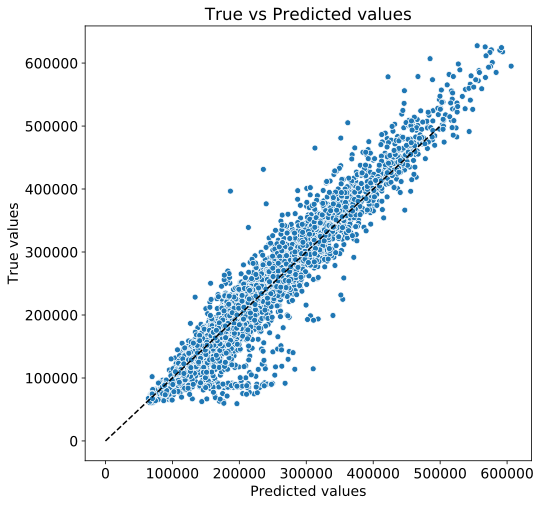

In [61]:
rf_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=7,
                                     min_samples_leaf=10,
                                     random_state=42,  
                                     n_estimators=100)
rf_model.fit(X_train, y_train)

y_train_preds = rf_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.742
RMSE:	48762.681
MSE:	2377799018.284


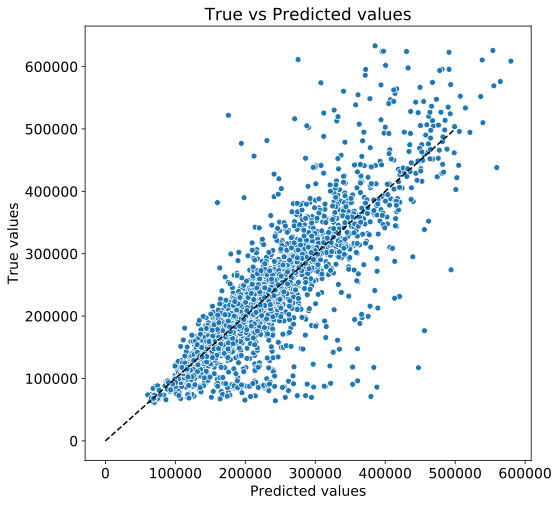

In [62]:
y_test_preds = rf_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

## Настройка и оценка финальной модели

In [63]:
# Кросс-валидация
rf_model = GradientBoostingRegressor(criterion='mse',
                          min_samples_leaf=10,
                          random_state=42,
                         # n_estimators=100,
                         # max_depth=7
                         )

In [64]:
%%time
params = {'n_estimators':[50, 100, 200, 400], 
          'max_depth':[3, 5, 7, 10]}

gs = GridSearchCV(rf_model, params, 
                  scoring='r2', # метрика 
                  cv=KFold(n_splits=5,   # k (кол-во разбиений/итераций) в кросс-валидации
                           random_state=21, 
                           shuffle=True),
                  n_jobs=-1
                  )
gs.fit(X_train, y_train)

Wall time: 1min 23s


GridSearchCV(cv=KFold(n_splits=5, random_state=21, shuffle=True),
             error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='mse', init=None,
                                                 learning_rate=0.1, loss='ls',
                                                 max_depth=3, max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=10,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter_no_change=None,
              

In [65]:
res = pd.DataFrame(gs.cv_results_)
res.head(2)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.647193      0.024402         0.002599         0.00049   
1       1.337771      0.045922         0.003799         0.00040   

  param_max_depth param_n_estimators                                 params  \
0               3                 50   {'max_depth': 3, 'n_estimators': 50}   
1               3                100  {'max_depth': 3, 'n_estimators': 100}   

   split0_test_score  split1_test_score  split2_test_score  split3_test_score  \
0           0.705904            0.70616           0.739700           0.734704   
1           0.713291            0.72311           0.754076           0.745398   

   split4_test_score  mean_test_score  std_test_score  rank_test_score  
0           0.729340         0.723162        0.014365               16  
1           0.749215         0.737018        0.015915               14

In [66]:
gs.best_params_

{'max_depth': 5, 'n_estimators': 200}

In [67]:
gs.best_score_

0.7550890287003981

R2:	0.893
RMSE:	29845.328
MSE:	890743590.674


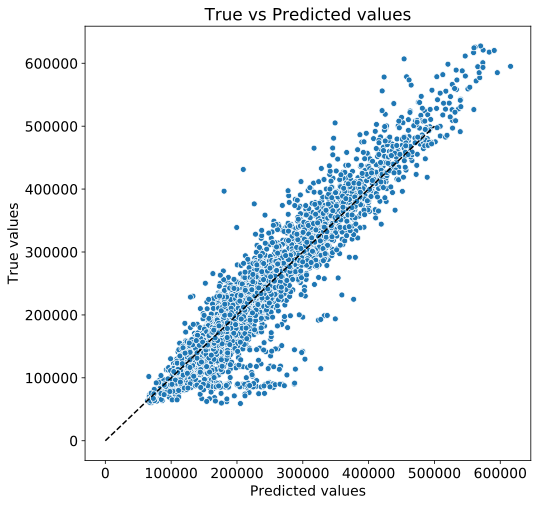

In [83]:
rf_model = GradientBoostingRegressor(criterion='mse',
                                        max_depth=5,
                                        min_samples_leaf=10,
                                        random_state=42,  
                                        n_estimators=200)

rf_model.fit(X_train, y_train)

y_train_preds = rf_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.743
RMSE:	48616.428
MSE:	2363557090.08


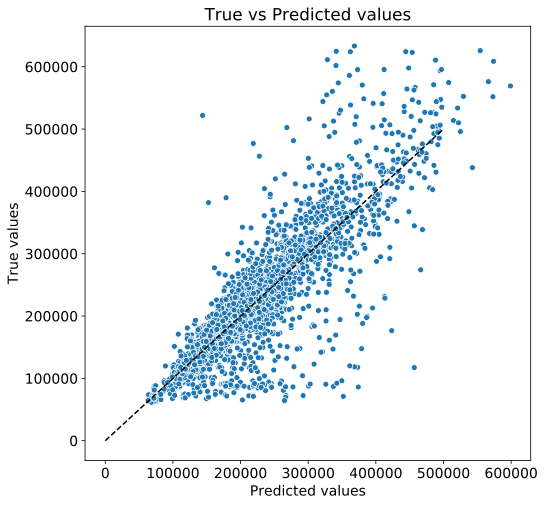

In [84]:
y_test_preds = rf_model.predict(X_test)
evaluate_preds(y_test, y_test_preds, save=True)

## Анализ прогнозов

In [85]:
rf_model.feature_importances_

array([8.20005490e-03, 1.08641289e-01, 1.36333499e-02, 3.23448491e-02,
       1.11341320e-02, 1.62923745e-02, 1.70400090e-02, 1.48848336e-02,
       0.00000000e+00, 6.56665271e-04, 1.45702970e-02, 1.35365022e-02,
       2.48395072e-02, 4.58732304e-03, 5.08640034e-03, 2.15368421e-04,
       6.97280823e-01, 1.70562219e-02])

In [86]:
feature_importances = pd.DataFrame(zip(X_train.columns, 
                                       rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False, inplace=True)

In [87]:
# топ 3 фич
feature_importances.head(3)

feature_name  importance
16  MedPriceByDistrict    0.697281
1               Square    0.108641
3        KitchenSquare    0.032345

In [88]:
# худшие фичи
feature_importances.tail(3)

feature_name  importance
9     Ecology_3    0.000657
15      Shops_2    0.000215
8     Ecology_2    0.000000

In [89]:
test = pd.read_csv(TEST_DATASET_PATH)
test.head()

Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
0  4567          44    1.0  36.847630   19.094182            5.0      5   
1  5925          62    1.0  42.493907   42.568133           10.0      7   
2   960          27    2.0  59.463678         NaN            9.0     19   
3  3848          23    3.0  49.646030   33.893825            6.0      2   
4   746          74    1.0  53.837056         NaN            1.0      8   

   HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  Social_2  \
0         9.0       1970   0.036122         B         B        24      4378   
1        17.0       2017   0.072158         B         B         2       629   
2        19.0       1977   0.211401         B         B         9      1892   
3         2.0       1965   0.014073         B         B         2       475   
4        17.0       1977   0.309479         B         B        35      7715   

   Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  
0         0        1036.0            1        1       B  
1         1           NaN            0        0       A  
2         0           NaN            0        1       B  
3         0           NaN            0        0       B  
4         4         990.0            0        6       B

In [90]:
test = pd.read_csv(TEST_DATASET_PATH)
predictions = rf_model.predict(test_df)
predictions

array([161888.34342543, 128139.44003149, 139520.07765881, ...,
       144217.60256098, 177789.47979592, 329857.87545099])

In [91]:
test = pd.read_csv(TEST_DATASET_PATH)
final = pd.DataFrame()

In [92]:
final['Id'] = test['Id'].copy()

In [93]:
final['Price'] = predictions

In [94]:
np.shape(test)

(5000, 19)

In [95]:
np.shape(predictions)

(5000,)

In [96]:
final.head()

Id          Price
0  4567  161888.343425
1  5925  128139.440031
2   960  139520.077659
3  3848  124958.768318
4   746  186636.919988

In [97]:
final.to_csv('Shishkova_ME.csv', index=False)